In [1]:
from collections import Counter
import csv
import math
import numpy as np
from sklearn.cluster import KMeans
import warnings
import matplotlib.pyplot as plt
import csv
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
def read_csv(filename):
    # Read data from a CSV file and return examples and attributes
    examples = []
    attributes = None
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            if attributes is None:
                attributes = row[1:-1]
            else:
                example = row[1:]
                examples.append(example)
    return examples, attributes

In [3]:
def map_values(examples, attributes):
    #Map all attributes, classes and values
    map_at=[]
    map_values=[]
    map_classes=[]
    for at in attributes:
        map_at.append(at)
    for i in range(len(map_at)):
        map_val=[]
        for example in examples:
            if example[i] not in map_val:
                map_val.append(example[i])
            if example[-1] not in map_classes:
                map_classes.append(example[-1])
        map_values.append(map_val)
    return map_at,map_values,map_classes

In [4]:
def categorize_continuous(data, attribute_index, n_classes,map_values):
    # Extract the feature values for the specified attribute
    feature_values = [example[attribute_index] for example in data]

    # Convert the feature values to a numpy array
    feature_array = np.array(feature_values).reshape(-1, 1)
    
    # Fit k-means clustering to the feature
    kmeans = KMeans(n_clusters=n_classes, random_state=0)
    kmeans.fit(feature_array)
    
    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    # Sort the cluster centers
    cluster_centers.sort(axis=0)
    
    # Calculate boundaries as the midpoint between consecutive cluster centers
    boundaries = [(cluster_centers[i] + cluster_centers[i+1]) / 2 for i in range(len(cluster_centers) - 1)]    
    map_values[attribute_index] = [f"<{boundaries[0][0]:.2f}"] + [f"[{boundaries[i][0]:.2f}, {boundaries[i+1][0]:.2f}]" for i in range(n_classes - 2)] + [f">{boundaries[-1][0]:.2f}"]

    # Return the boundaries
    return boundaries

def boundaries_function(value, boundaries):
    # Iterate through the boundaries to find the class index
    for i, boundary in enumerate(boundaries):
        if value <= boundary[0]:
            return i
    # If the value is greater than the last boundary, assign it to the last class
    return len(boundaries)

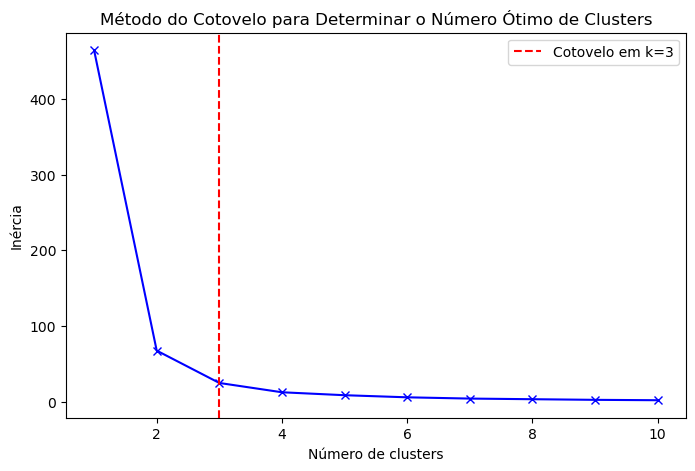

O melhor número de clusters é: 3


In [5]:
def calculate_inertia(data, max_clusters=10):
    feature_array = np.array(data).reshape(-1, 1)
    inertia = []
    K = range(1, max_clusters + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(feature_array)
        inertia.append(kmeans.inertia_)

    return K, inertia

def elbow_method(data, max_clusters=10):
    K, inertia = calculate_inertia(data, max_clusters)
    
    # Criação de linha reta entre o primeiro e o último ponto de inércia
    point1 = np.array([1, inertia[0]])
    point2 = np.array([max_clusters, inertia[-1]])
    line = np.linspace(point1, point2, max_clusters)

    # Calculando as distâncias perpendiculares entre a linha reta e os pontos de inércia
    distances = np.abs(np.cross(point2-point1, point1-np.array([K, inertia]).T)) / np.linalg.norm(point2-point1)
    
    # Encontrando o ponto de maior distância
    elbow_point = np.argmax(distances) + 2  # +2 para ajustar o índice do cluster
    
    # Plotando o gráfico do método do cotovelo
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inércia')
    plt.title('Método do Cotovelo para Determinar o Número Ótimo de Clusters')
    plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Cotovelo em k={elbow_point}')
    plt.legend()
    plt.show()

    return elbow_point

# Exemplo de uso com um atributo numérico do conjunto de dados Iris
from sklearn.datasets import load_iris
iris = load_iris()
data = iris.data[:, 2]  # Usando petal length (comprimento da pétala)

# Encontrar o número ideal de clusters para petal length
best_k = elbow_method(data)
print(f"O melhor número de clusters é: {best_k}")


In [6]:
def preprocess_examples(examples, attributes,map_at,map_values,map_classes):
    k=best_k
    processed_examples = []
    processed_attributes=[]
    boundaries = [0] * len(attributes)
    for example in examples:
        processed_example = []
        for i in range(len(example)-1):
            try:
                example[i]=int(example[i])
                if boundaries[i]==0:
                    boundaries[i]=categorize_continuous(examples,i,k,map_values)
                processed_example.append(boundaries_function(example[i],boundaries[i]))
            except:
                try:
                    example[i]=float(example[i])
                    if boundaries[i]==0:
                        boundaries[i]=categorize_continuous(examples,i,k,map_values)
                    processed_example.append(boundaries_function(example[i],boundaries[i]))
                except:
                    processed_example.append(map_values[i].index(example[i]))
        processed_example.append(map_classes.index(example[-1]))  
        processed_examples.append(processed_example)
    for attr in attributes:
        processed_attributes.append(map_at.index(attr))
    return processed_examples, processed_attributes, boundaries

In [7]:
def plurality_value(examples):
    # Return the most common classification in the examples
    counts = Counter(examples)
    return max(counts, key=counts.get)

In [8]:
def learn_decision_tree(examples, attributes,map1,original_examples,count=0,parent_examples=None):
    if len(examples) == 0:
        # If examples is empty, return the plurality value of the parent examples
        return plurality_value(example[-1] for example in parent_examples),0
    elif len(set(example[-1] for example in examples)) == 1:
        # If all examples have the same classification, return the classification
        return examples[0][-1],len(examples)
    elif len(attributes) == 0:
        # If attributes is empty, return the plurality value of the current examples
        return plurality_value([example[-1] for example in examples]),len(examples)
    else:
        # Choose the attribute with the highest importance
        A = max(attributes, key=lambda a: importance(a, examples,len(map1[a])))
        tree = {'attribute': A, 'branches': {}}
        for v in set(example[A] for example in original_examples):
            exs = [example for example in examples if example[A] == v]
            subtree = learn_decision_tree(exs, [attr for attr in attributes if attr != A],map1,original_examples,count, examples)
            tree['branches'][v] = subtree
        return tree

In [9]:
def learn_decision_tree_pruning(examples, attributes, map1, original_examples, count=0, parent_examples=None):
    if len(examples) == 0:
        # Se exemplos está vazio, retornar o valor de pluralidade dos exemplos do pai
        return plurality_value(example[-1] for example in parent_examples), 0
    elif len(set(example[-1] for example in examples)) == 1:
        # Se todos os exemplos têm a mesma classificação, retornar a classificação
        return examples[0][-1], len(examples)
    elif len(attributes) == 0:
        # Se os atributos estão vazios, retornar o valor de pluralidade dos exemplos atuais
        return plurality_value([example[-1] for example in examples]), len(examples)
    else:
        # Verificar se todas as classes têm pelo menos 3 exemplos
        class_counts = {}
        for example in examples:
            class_label = example[-1]
            if class_label in class_counts:
                class_counts[class_label] += 1
            else:
                class_counts[class_label] = 1
        
        if any(count < 3 for count in class_counts.values()):
            # Se alguma classe tem menos de 3 exemplos, retornar o valor de pluralidade dos exemplos atuais
            return plurality_value([example[-1] for example in examples]), len(examples)
        
        # Escolher o atributo com a maior importância
        A = max(attributes, key=lambda a: importance(a, examples, len(map1[a])))
        tree = {'attribute': A, 'branches': {}}
        for v in set(example[A] for example in original_examples):
            exs = [example for example in examples if example[A] == v]
            subtree = learn_decision_tree_pruning(exs, [attr for attr in attributes if attr != A], map1, original_examples, count, examples)
            tree['branches'][v] = subtree
        return tree

In [10]:
def entropy(probabilities):
    """
    Calculate the entropy given a list of probabilities.
    """
    entropy_val = 0
    for prob in probabilities:
        if prob!=0:
            entropy_val -= prob * math.log2(prob)
    return entropy_val

def remainder(pk, p):
    """
    Calculate the remainder for a given attribute.
    """
    remainder_val = 0
    for k in range(len(pk[0])):
        um=pk[0][k]
        dois=pk[1][k]
        if um+dois != 0:
            remainder_val += (((um+dois) / p) * entropy([um/(um+dois),dois/(um+dois)]))
    return remainder_val

def information_gain(pk, p):
    """
    Calculate the information gain for a given attribute.
    """
    base_entropy = entropy([sum(pk_val) / p for pk_val in pk])
    remainder_val = remainder(pk, p)
    return base_entropy - remainder_val

def importance(attribute, examples,num):
    """
    Calculate the gain of a given attribute.
    """
    target_classes = set([example[-1] for example in examples])
    class_count = len(target_classes)
    p = len(examples)
    pk = {target_class: [0] * num for target_class in target_classes}
    ver=[False]*num
    # Count positive examples for each target class
    for example in examples:
        pk[example[-1]][example[attribute]] += 1
        ver[example[attribute]]=True
        
    if sum(ver)==1:
        return -1
    
    info_gain=information_gain([pk_val for pk_val in pk.values()], p)
    
    return info_gain

In [11]:
def print_tree(tree,map_at,map_values,map_classes,indent=0):
    if isinstance(tree,tuple):
        print(map_classes[tree[0]] + " (%d)" % tree[1])
    else:
        attribute = tree['attribute']
        branches = tree['branches']
        print(' ' * indent + f'Attribute: {map_at[attribute]}')
        for value, subtree in branches.items():
            print(' ' * (indent + 4) + f'Value {map_values[attribute][value]}:', end=' ')
            print_tree(subtree,map_at,map_values,map_classes, indent + 8)

In [12]:
def decision_tree(csv_file):
    examples,attributes=read_csv(csv_file)
    map,map1,map2=map_values(examples,attributes)
    ex,at,bound=preprocess_examples(examples,attributes,map,map1,map2)
    tree=learn_decision_tree(ex,at,map1,ex)
    #tree=learn_decision_tree_pruning(ex,at,map1,ex)
    print_tree(tree,map,map1,map2)
    return tree,map1,map2,bound

In [13]:
def predict_class(tree, input_attributes, map1,map2,boundaries,processed_input,processed):
    if not processed:
        for i in range(len(input_attributes)):
            try:
                input_attributes[i]=int(input_attributes[i])
                processed_input.append(boundaries_function(input_attributes[i],boundaries[i]))
            except:
                try:
                    input_attributes[i]=float(input_attributes[i])
                    processed_input.append(boundaries_function(input_attributes[i],boundaries[i]))
                except:
                    processed_input.append(map1[i].index(input_attributes[i]))
        
    # If the current node is a leaf node (i.e., a class prediction)
    if isinstance(tree, tuple):
        return map2[tree[0]]
    
    # Get the attribute from the current node
    attribute = tree['attribute']
    
    # Get the value of the attribute from the input attributes
    attribute_value = processed_input[attribute]
    
    # If the value is not found in the branches of the tree, return None
    if attribute_value not in tree['branches']:
        print(input_attributes)
        print("Ramo não encontrado")
        return None
    
    # Recursively traverse the tree based on the attribute value
    return predict_class(tree['branches'][attribute_value], processed_input,map1,map2,boundaries,processed_input,True)


In [14]:
def predict_from_a_file(examples,input_file):
    input_file_processed=read_csv(input_file)[0]
    tree,map1,map2,boundaries=decision_tree(examples)
    for line in input_file_processed:
        print(predict_class(tree,line,map1,map2,boundaries,[],False))

In [15]:
def create_random_iris_csv(num_rows):
    with open("iris.csv", newline='') as input_csv_file:
        reader = csv.reader(input_csv_file)
        rows = list(reader)
        header = rows[0][:-1]
        with open('random.csv', mode='w', newline='') as output_csv_file:
            writer = csv.writer(output_csv_file)
            writer.writerow(header)
            for i in range(1,num_rows+1):
                sepal_length = round(random.uniform(4.3, 7.9), 1)
                sepal_width = round(random.uniform(2.0, 4.4), 1)
                petal_length = round(random.uniform(1.0, 6.9), 1)
                petal_width = round(random.uniform(0.1, 2.5), 1)
                writer.writerow([i]+[sepal_length]+[sepal_width]+[petal_length]+[petal_width])
        predict_from_a_file("iris.csv","random.csv")    
            


In [16]:
tree,map1,map2,bound=decision_tree("weather.csv")

Attribute: Weather
    Value sunny:         Attribute: Humidity
            Value <76.38: yes (2)
            Value [76.38, 87.58]: no (1)
            Value >87.58: no (2)
    Value overcast: yes (4)
    Value rainy:         Attribute: Windy
            Value FALSE: yes (3)
            Value TRUE: no (2)


In [17]:
create_random_iris_csv(50)

Attribute: petallength
    Value <2.85: Iris-setosa (50)
    Value [2.85, 4.89]:         Attribute: petalwidth
            Value <0.78: Iris-versicolor (0)
            Value [0.78, 1.69]: Iris-versicolor (45)
            Value >1.69:                 Attribute: sepalwidth
                    Value <2.83: Iris-virginica (2)
                    Value [2.83, 3.35]:                         Attribute: sepallength
                            Value <5.45: Iris-versicolor (0)
                            Value [5.45, 6.46]: Iris-versicolor (2)
                            Value >6.46: Iris-versicolor (0)
                    Value >3.35: Iris-virginica (0)
    Value >4.89:         Attribute: petalwidth
            Value <0.78: Iris-virginica (0)
            Value [0.78, 1.69]:                 Attribute: sepallength
                    Value <5.45: Iris-virginica (0)
                    Value [5.45, 6.46]:                         Attribute: sepalwidth
                            Value <2.83: Iris-v